# Part 2: Generalization across subjects
## Import required libraries

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.ndimage import convolve1d

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, pairwise_distances
from sklearn.linear_model import LinearRegression
from scipy import stats

In [2]:
from functions import *

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

## Load and extract data

In [6]:
# Define the base path to the zip files and the extraction directory
base_zip_path = '../data/'
extraction_dir = '../data/'
id_column, emg, stimuli, repetitions = load_and_concatenate_subjects(base_path=base_zip_path, extraction_dir=extraction_dir, num_subjects=27, isZipped=False)

In [8]:
# print data shape
print('EMG shape:', emg.shape)
print('Stimulus shape:', stimuli.shape)
print('Repetitions shape:', repetitions.shape)

EMG shape: (2731393, 10)
Stimulus shape: (2731393, 1)
Repetitions shape: (2731393, 1)


## Preprocess data

In [ ]:
# Apply bandpass filter to the data
emg_filtered = bandpass_filter(emg)

# Rectify the signal
emg_rectified = np.abs(emg_filtered)

# Envelop the signal using a moving average filter
mov_mean_size = 200
mov_mean_weights = np.ones(mov_mean_size) / mov_mean_size
emg_envelopes = convolve1d(emg_rectified, weights=mov_mean_weights, axis=0) # convolve1d the rectified signal with the moving average weights

n_stimuli = len(np.unique(stimuli)) - 1 
n_repetitions = len(np.unique(repetitions)) - 1 

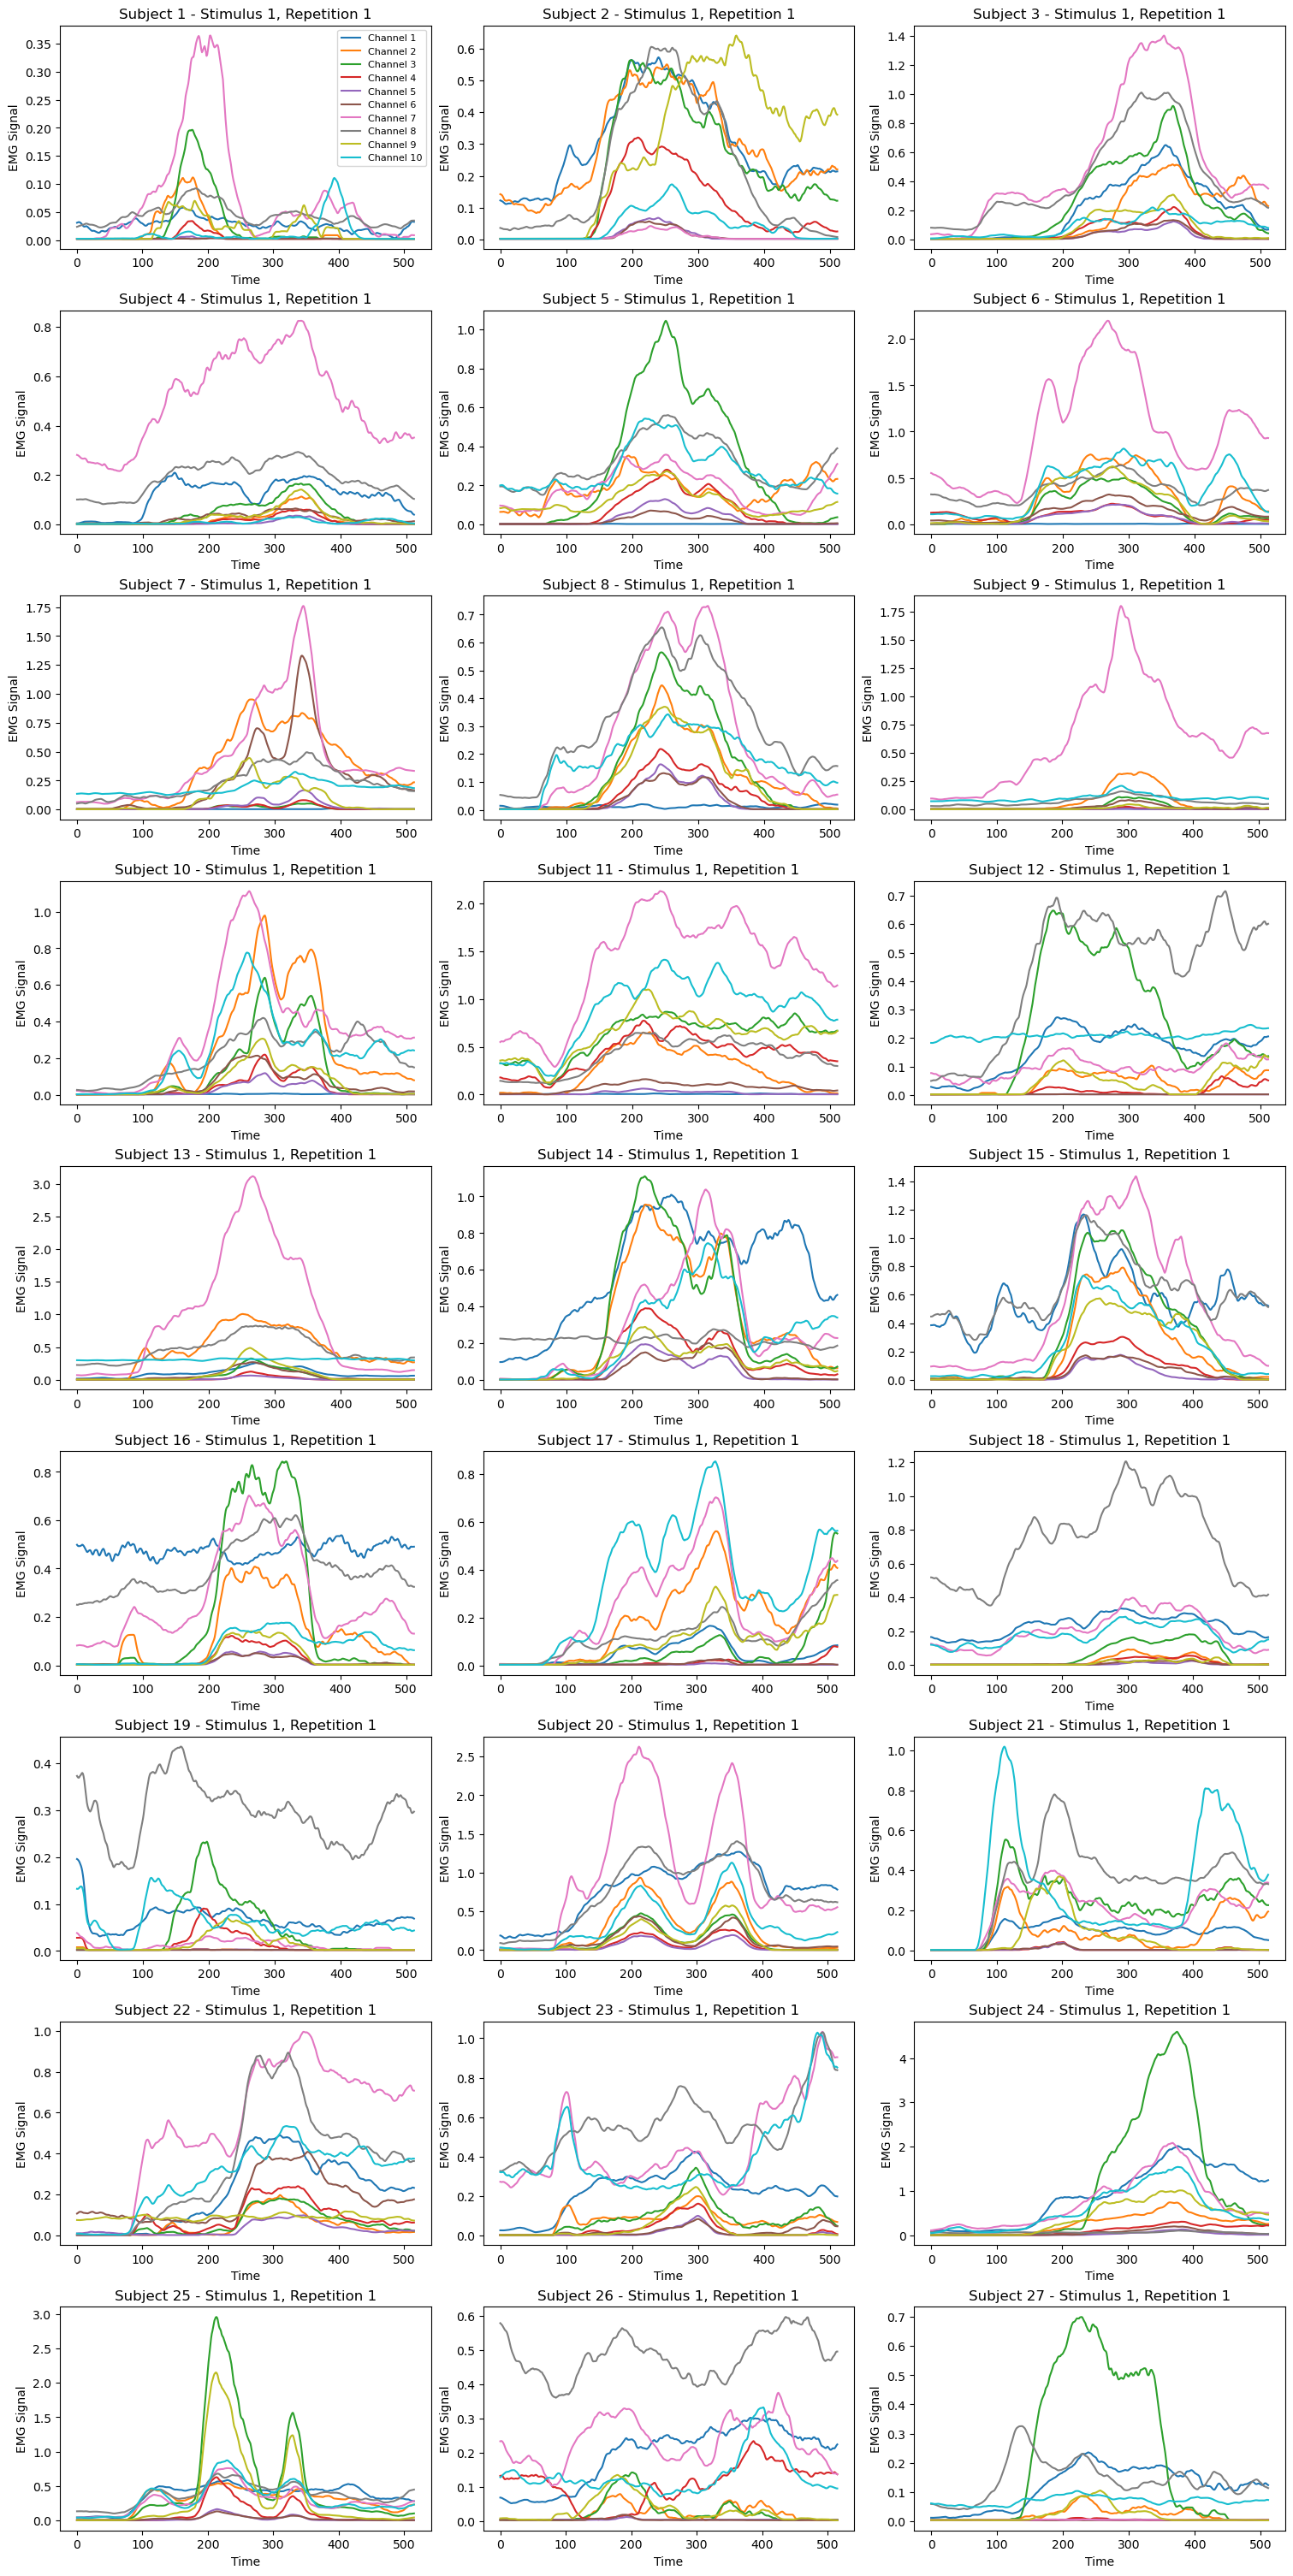

In [16]:
# Define the length of the moving average window
mov_mean_length = 25
mov_mean_weights = np.ones(mov_mean_length) / mov_mean_length

# Number of subjects (adjust if needed)
unique_subjects = np.unique(id_column)

# Initialize a color map for distinct colors
def colors(index):
    """Return a color based on the index."""
    color_list = plt.cm.tab10.colors  # A predefined colormap
    return color_list[index % len(color_list)]

# Create a 9x3 layout for the plots
fig, axes = plt.subplots(9, 3, figsize=(15, 30), constrained_layout=True)
axes = axes.ravel()

# Iterate over all subjects and plot their emg_envelopes
for i, subject_num in enumerate(unique_subjects):
    # Filter data for the current subject
    subject_mask = id_column == subject_num
    emg_subject = emg[subject_mask, :]
    stimulus_subject = stimuli[subject_mask]
    repetition_subject = repetitions[subject_mask]

    # Initialize the data structure for current subject
    emg_windows_subject = [[None for _ in range(n_repetitions)] for _ in range(n_stimuli)]
    emg_envelopes_subject = [[None for _ in range(n_repetitions)] for _ in range(n_stimuli)]

    # Compute emg_windows and emg_envelopes for the current subject
    for stimuli_idx in range(n_stimuli):
        for repetition_idx in range(n_repetitions):
            idx = np.logical_and(stimulus_subject == stimuli_idx + 1, repetition_subject == repetition_idx + 1).flatten()
            emg_windows_subject[stimuli_idx][repetition_idx] = emg_subject[idx, :]
            emg_envelopes_subject[stimuli_idx][repetition_idx] = convolve1d(emg_windows_subject[stimuli_idx][repetition_idx], mov_mean_weights, axis=0)

    # Extract the emg envelope for the first stimulus and first repetition
    emg_envelope_first_stimuli_repetition = emg_envelopes_subject[0][0]

    # Plot the envelope for the first stimulus and first repetition
    ax = axes[i]
    for channel_idx in range(emg_envelope_first_stimuli_repetition.shape[1]):  # Iterate over channels
        ax.plot(emg_envelope_first_stimuli_repetition[:, channel_idx], color=colors(channel_idx), label=f'Channel {channel_idx+1}')
    ax.set_title(f"Subject {int(subject_num)} - Stimulus 1, Repetition 1")
    ax.set_xlabel("Time")
    ax.set_ylabel("EMG Signal")

# Add a legend to the first subplot
axes[0].legend(loc='upper right', prop={'size': 8})

plt.show()

## Feature Extraction

In [19]:
# Build the dataset and labels
dataset, labels, subject_id_column = build_dataset_from_ninapro_all_subjects(
    subject_id_column=id_column,
    emg=emg,
    stimulus=stimuli,
    repetition=repetitions,
    features=[mav, std, maxav, rms, wl, ssc, total_power],
)

print(f"Dataset dimension: {dataset.shape}")
print(f"Labels dimension: {labels.shape}")
print(f"Subject ID column dimension: {subject_id_column.shape}")

Dataset dimension: (3240, 70)
Labels dimension: (3240,)
Subject ID column dimension: (3240,)


/var/folders/q_/xhgs30s966s2xsy_tl8w2k680000gp/T/ipykernel_74087/1139099131.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(means_subjects, labels=[f'Feature {i+1}' for i in range(n_features)])
/var/folders/q_/xhgs30s966s2xsy_tl8w2k680000gp/T/ipykernel_74087/1139099131.py:39: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(stds_subjects, labels=[f'Feature {i+1}' for i in range(n_features)])


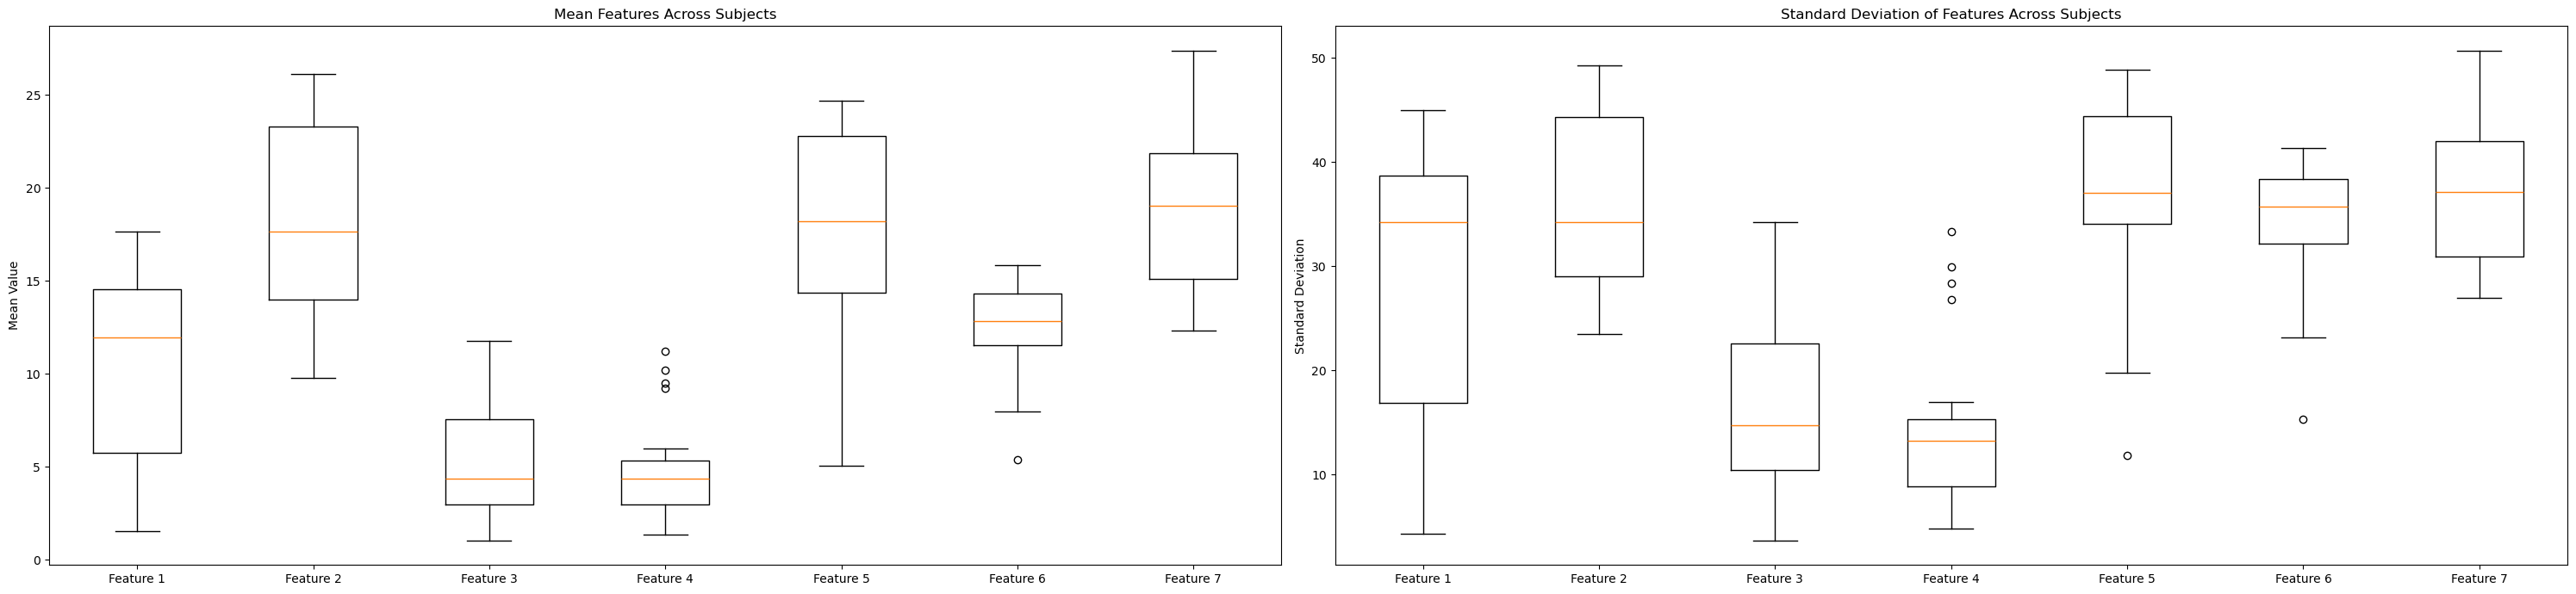

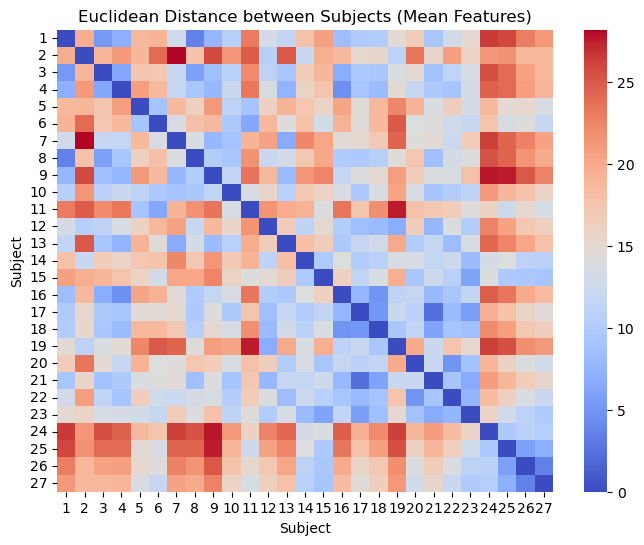

In [26]:
# Define the features (assuming you've already defined these, e.g., MAV, STD, etc.)
# We already have `dataset`, `labels`, and `subject_id_column`

# Calculate means and standard deviations for each feature across subjects

# Get unique subjects
unique_subjects = np.unique(subject_id_column).astype(int)
num_trials = 10 
n_features = int(dataset.shape[1] / num_trials)

# Initialize arrays to store the mean and std for each feature and subject
means_subjects = np.zeros((len(unique_subjects), n_features))
stds_subjects = np.zeros((len(unique_subjects), n_features))

# Reshape dataset for each subject's feature across trials
for i, subject in enumerate(unique_subjects):
    subject_mask = subject_id_column == subject
    emg_subject = dataset[subject_mask]  # Select the rows corresponding to the current subject
    # Reshape: Each feature will be grouped across trials for the current subject
    for feature_idx in range(n_features):
        feature_data = emg_subject[:, feature_idx*num_trials:(feature_idx+1)*num_trials]  # Select data for one feature
        means_subjects[i, feature_idx] = np.mean(feature_data)  # Mean across trials for the feature
        stds_subjects[i, feature_idx] = np.std(feature_data)    # Standard deviation across trials for the feature

# Visualize the mean and standard deviation of features across subjects
plt.figure(figsize=(30, 7))

# Plot mean features
plt.subplot(1, 2, 1)

plt.title('Mean Features Across Subjects')
plt.boxplot(means_subjects, labels=[f'Feature {i+1}' for i in range(n_features)])
plt.ylabel('Mean Value')


# Plot std features
plt.subplot(1, 2, 2)
plt.title('Standard Deviation of Features Across Subjects')
plt.boxplot(stds_subjects, labels=[f'Feature {i+1}' for i in range(n_features)])
plt.ylabel('Standard Deviation')
plt.tight_layout()

plt.show()

# Compare similarity across subjects using Euclidean distance
distances = pairwise_distances(means_subjects, metric='euclidean')

# Visualize the Euclidean distance matrix between subjects
plt.figure(figsize=(8, 6))
sns.heatmap(distances, cmap='coolwarm', xticklabels=unique_subjects, yticklabels=unique_subjects)
plt.title("Euclidean Distance between Subjects (Mean Features)")
plt.xlabel("Subject")
plt.ylabel("Subject")
plt.show()

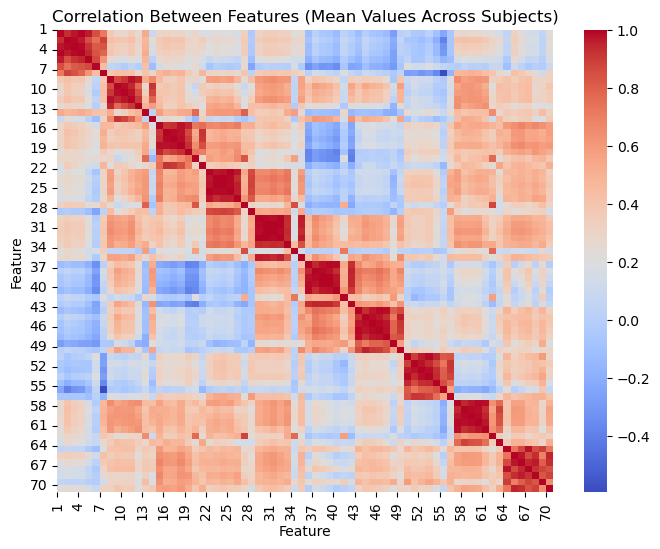

In [31]:
n_features = dataset.shape[1]

# Initialize arrays to store the mean and std for each feature and subject
means_subjects = np.zeros((len(unique_subjects), n_features))
stds_subjects = np.zeros((len(unique_subjects), n_features))

# Calculate mean and std for each feature per subject
for i, subject in enumerate(unique_subjects):
    subject_mask = subject_id_column == subject
    means_subjects[i] = np.mean(dataset[subject_mask], axis=0)
    stds_subjects[i] = np.std(dataset[subject_mask], axis=0)

# Optionally, you can also check correlation across subjects for each feature
correlation_matrix = np.corrcoef(means_subjects, rowvar=False)

# Visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, cmap='coolwarm', xticklabels=np.arange(1, n_features + 1), yticklabels=np.arange(1, n_features + 1))
plt.title("Correlation Between Features (Mean Values Across Subjects)")
plt.xlabel("Feature")
plt.ylabel("Feature")
plt.xticks(ticks=np.arange(0, n_features, 3), labels=np.arange(1, n_features + 1, 3))
plt.yticks(ticks=np.arange(0, n_features, 3), labels=np.arange(1, n_features + 1, 3))
plt.show()

## Classifier

Accuracy score: 0.16666666666666666


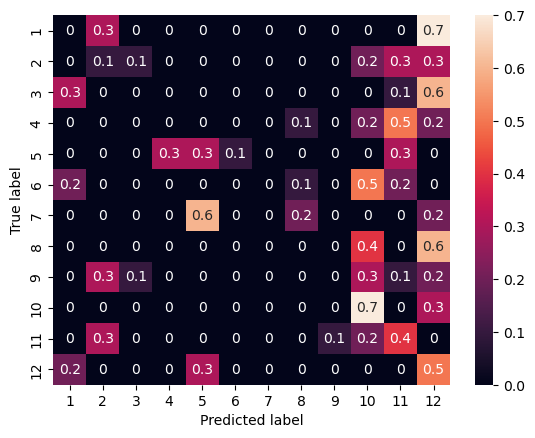

In [32]:
# Create train from the first 26 subject and test with the last subejct
X_train = dataset[subject_id_column != 27]
y_train = labels[subject_id_column != 27]

X_test = dataset[subject_id_column == 27]
y_test = labels[subject_id_column == 27]

# Normalizing the data
# StandardScaler is used to scale the features so that they have a mean of 0 and a standard deviation of 1
scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train)  # Fit the scaler on the training data and transform it
X_test_z = scaler.transform(X_test)        # Transform the test data using the same scaler

# Train a classifier on the normalized data
# We are using RandomForestClassifier from sklearn
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_z, y_train)  # Fit the model on the training data

# Evaluate the classifier on the test set
# Predict the labels for the test set
y_pred = clf.predict(X_test_z)
# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score: {accuracy}")

# Create a confusion matrix to visualize the performance of the classification
# The confusion matrix shows the true vs predicted labels
confmat = confusion_matrix(y_test, y_pred, normalize="true")
fig, ax = plt.subplots()
sns.heatmap(confmat, annot=True, ax=ax)  # Use seaborn to create a heatmap of the confusion matrix
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
ax.set_xticklabels(range(1, len(confmat) + 1))
ax.set_yticklabels(range(1, len(confmat) + 1))
plt.show()

In [ ]:
accuracies = []
# rotate the subject used for testing
for subject in range(1, 28):
    X_train = dataset[subject_id_column != subject]
    y_train = labels[subject_id_column != subject]

    X_test = dataset[subject_id_column == subject]
    y_test = labels[subject_id_column == subject]

    X_train_z = scaler.fit_transform(X_train)
    X_test_z = scaler.transform(X_test)

    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train_z, y_train)

    y_pred = clf.predict(X_test_z)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    print(f"Subject used for testing {subject} - Accuracy: {accuracy}")

# Plot the accuracy for each subject
plt.figure(figsize=(10, 6))
plt.plot(range(1, 28), accuracies, marker='o')
plt.title("Accuracy for Each Subject")
plt.axhline(np.mean(accuracies), color='r', linestyle='--', label='Mean Accuracy')
plt.xlabel("Subject used for testing")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


Subject used for testing 1 - Accuracy: 0.26666666666666666
Subject used for testing 2 - Accuracy: 0.13333333333333333
Subject used for testing 3 - Accuracy: 0.36666666666666664
Subject used for testing 4 - Accuracy: 0.3333333333333333
Subject used for testing 5 - Accuracy: 0.425
Subject used for testing 6 - Accuracy: 0.23333333333333334
Subject used for testing 7 - Accuracy: 0.275
Subject used for testing 8 - Accuracy: 0.475
Subject used for testing 9 - Accuracy: 0.16666666666666666
Subject used for testing 10 - Accuracy: 0.5
Subject used for testing 11 - Accuracy: 0.375
Subject used for testing 12 - Accuracy: 0.2916666666666667


1 Subjects used for training  - Accuracy when predicting subject 27 : 0.09166666666666666
2 Subjects used for training  - Accuracy when predicting subject 27 : 0.08333333333333333
3 Subjects used for training  - Accuracy when predicting subject 27 : 0.25
4 Subjects used for training  - Accuracy when predicting subject 27 : 0.15833333333333333
5 Subjects used for training  - Accuracy when predicting subject 27 : 0.06666666666666667
6 Subjects used for training  - Accuracy when predicting subject 27 : 0.15833333333333333
7 Subjects used for training  - Accuracy when predicting subject 27 : 0.125
8 Subjects used for training  - Accuracy when predicting subject 27 : 0.10833333333333334
9 Subjects used for training  - Accuracy when predicting subject 27 : 0.10833333333333334
10 Subjects used for training  - Accuracy when predicting subject 27 : 0.13333333333333333
11 Subjects used for training  - Accuracy when predicting subject 27 : 0.11666666666666667
12 Subjects used for training  - Accu

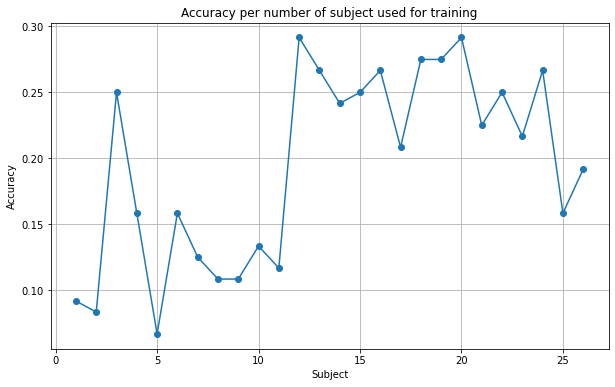

In [ ]:
accuracies = []
# rotate the subject used for testing
for subject in range(1, 27):
    X_train = dataset[subject_id_column <= subject]
    y_train = labels[subject_id_column <= subject]

    X_test = dataset[subject_id_column == 27]
    y_test = labels[subject_id_column == 27]

    X_train_z = scaler.fit_transform(X_train)
    X_test_z = scaler.transform(X_test)

    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train_z, y_train)

    y_pred = clf.predict(X_test_z)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    print(f"{subject} Subjects used for training  - Accuracy when predicting subject 27 : {accuracy}")


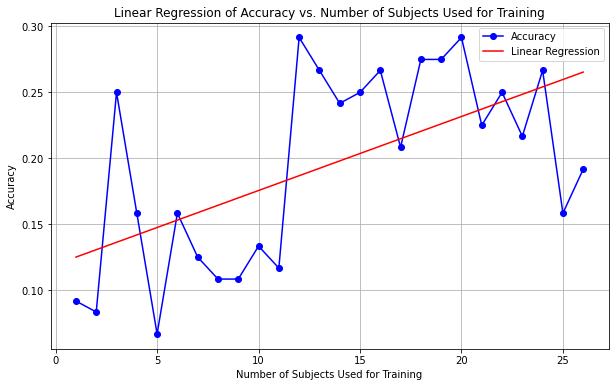

U-statistic: 0.0, P-value: 3.97485483636119e-11


In [ ]:
subject_range = range(1, 27)  # Subjects from 1 to 26
# 1. **Linear Regression to test for statistical increase**
X = np.array(subject_range).reshape(-1, 1)  # Number of subjects
y = np.array(accuracies)  # Corresponding accuracies


# Fit a linear regression model
regressor = LinearRegression()
regressor.fit(X, y)

# Get the regression line
y_pred_regression = regressor.predict(X)

# Plot the linear regression result
plt.figure(figsize=(10, 6))
plt.plot(subject_range, accuracies, color='blue', marker = 'o', label='Accuracy')
plt.plot(subject_range, y_pred_regression, color='red', label='Linear Regression')
plt.title("Linear Regression of Accuracy vs. Number of Subjects Used for Training")
plt.xlabel("Number of Subjects Used for Training")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

U_stat, p_value = stats.mannwhitneyu(accuracies, [0.5] * len(accuracies), alternative='two-sided')
print(f"U-statistic: {U_stat}, P-value: {p_value}")